0
######## ----------- START POLICY ITERATION ------------------##########
######## ----------- START POLICY ITERATION ------------------##########
######## ----------- START POLICY ITERATION ------------------##########
######## ----------- START POLICY ITERATION ------------------##########
######## ----------- START POLICY ITERATION ------------------##########
######## ----------- START POLICY ITERATION ------------------##########


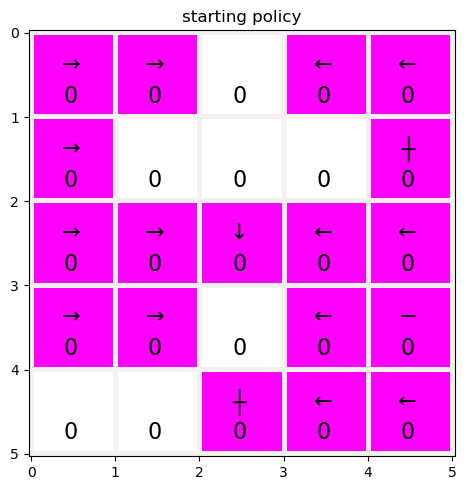

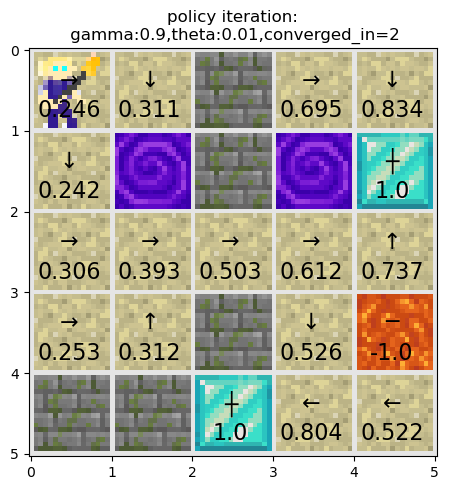

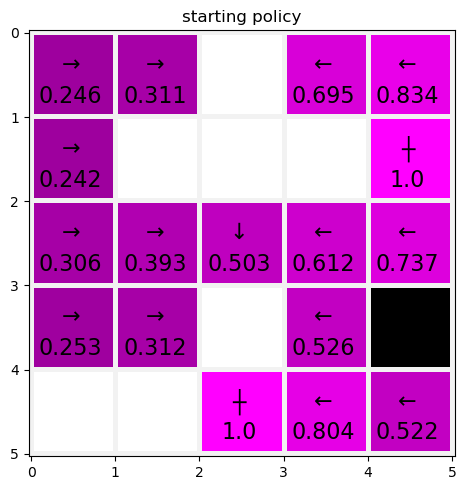

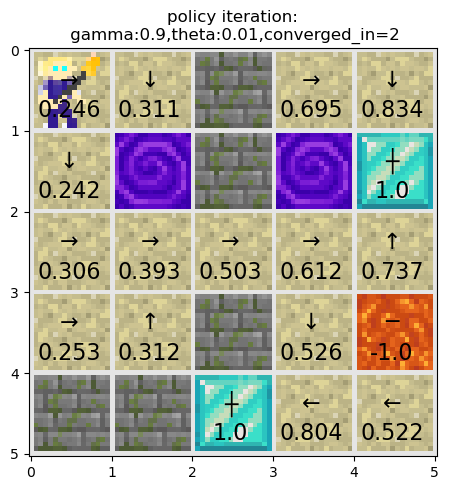

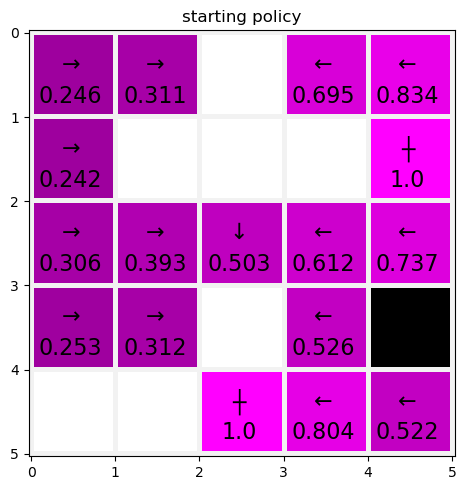

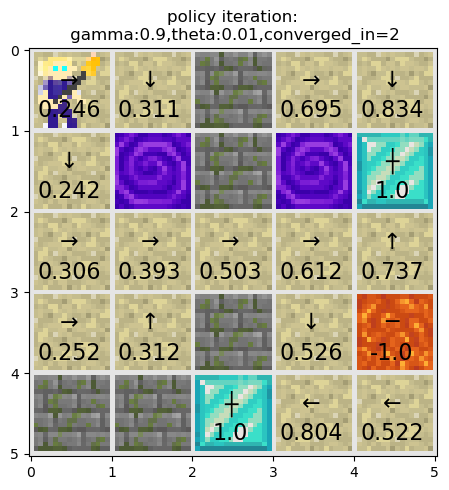

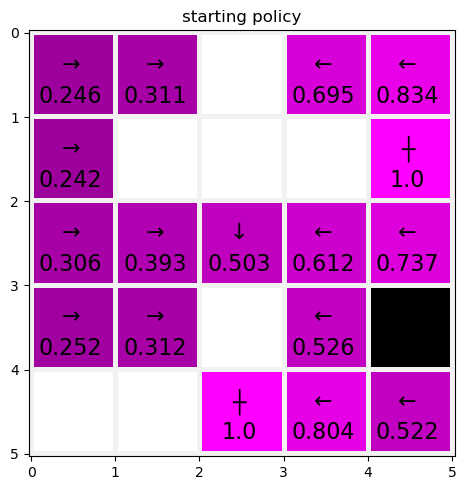

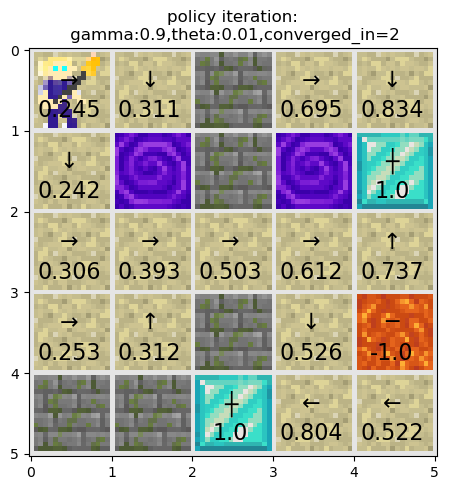

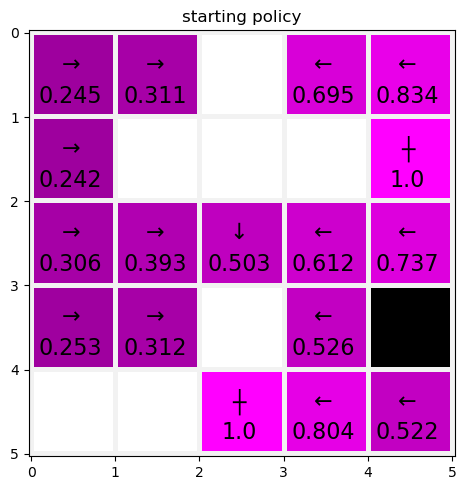

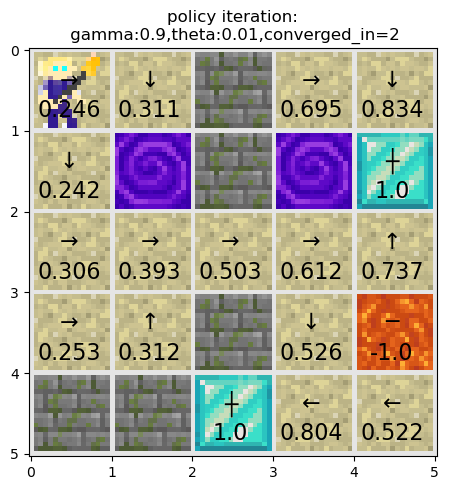

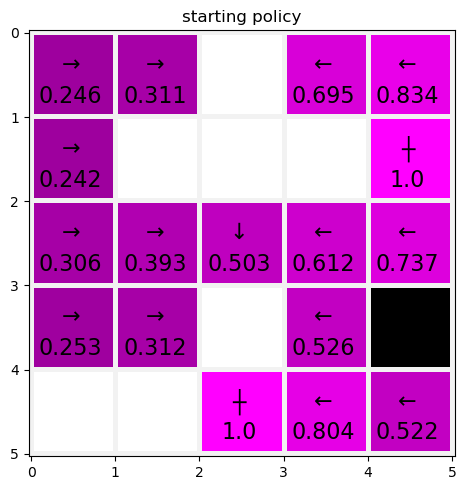

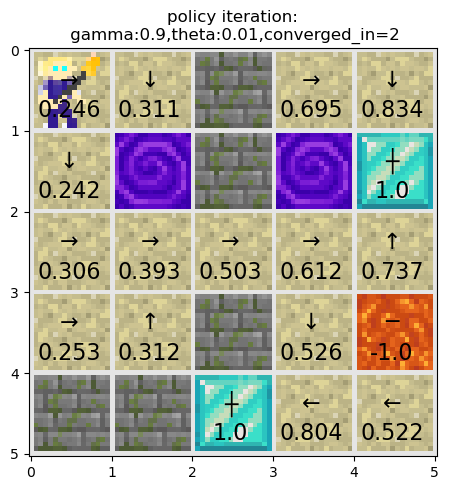

3121616048.py - 105 - INFO : ############################## Done ##############################


In [3]:
from rl_agent import Agent # own implementations
from rl_environment import GridWorld # own implementations
from rl_render import Render # own implementations
import numpy as np 
import matplotlib.pyplot as plt
import logging
import warnings

import copy

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(finame)s - %(lineno)d - %(levelname)s : %(message)s',
                     datefmt='%H:%M:%S')
logger = logging.getLogger('my-logger')
# logger.propagate = False
logger.disabled = True

# ploting settings
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

def test():
    a = np.zeros((5,5,4))
    a[0,0,0] = 4
    a[0,0,1] = 4
    a[0,0,2] = 3
    a[0,0,3] = 4
    print(np.argmax(a[0,0,:]))

if __name__ == "__main__":
    test()

    # variables for training
    episodes_list = [10,50,200,500,1000,10000]
    # for both value iteration and MC estimates
    gamma=0.9
    # only for value iteration
    theta=0.01
    ignore_converged_s=0.2
    # only for MC estimates
    max_steps_per_iteration=100

    # variables for rendering , of one cell in the grid
    scale = 16

    # creating simple grid
    world = GridWorld(5,5 ,
            terminalState={'goal': [(1,4)],
                        'negative_goal': [(3,4)]},
            terrain={'wall': [(0,2),(1,2),(3,2)]},
            setRewards= {'default': -0.02},
            environmentDynamics='stochastic')
    # creating an agent in the gridworld
    agent = Agent(environment=world)
    # creating render object 
    render = Render(env=world, agent=agent, scale=scale)
    # initiate rendering resources
    render.init_rendering_resources(configuration=0)
    # render.start()

    # show simple grid
    # render.renderEnv(style='image', title='Simple Grid', results=False)

    # adding more complexity to the grid (terrains and goals)
    world.addTerminal(('goal',[(4,2)]))
    world.addTerrain(('wall',[(4,0),(4,1)]),('shortcut', [(1,1),(1,3)]))
    # show complex grid
    # render.renderEnv(style='image', title='more complex Grid', results=False)
    # delete objects from the grid
    # world.deleteObject((4,0),(4,2))
    # render.renderEnv(style='image', title='more complex Grid', results=False)s

    # trainig a model for x episodes using value iteration and MC estimates
    for episodes in episodes_list:

        # if episodes in episodes_list[:3]: # value iteration
        #     _ , iterations = agent.valueIteration(world, max_iterations=episodes, gamma=gamma, theta=theta , ignore=ignore_converged_s) 
        #     render.renderEnv(style='image', results=True,
        #         title=f'value iteration:\n gamma:{gamma},theta:{theta},ignore:{ignore_converged_s},converged_in={iterations}')
            
        # if episodes in episodes_list[:3]: # MC estimates policy evaluation
        #     agent.policy = agent.policyGenerator(world)
        #     agent.evaluatePolicyLoop_MC(world, policy=agent.policy, samples=episodes , max_steps=max_steps_per_iteration)
        #     agent.policy = agent.prob_to_determin_policy(world, agent.policy)
        #     render.renderEnv(style='color map', results=True,
        #         title=f'MC estimates on heuristic policy:\n gamma:{gamma},max_stpPerIter:{max_steps_per_iteration},episodes={episodes}')


        if episodes in episodes_list[:]: # policy iteration # TODO: fix policy iteration
            heuristic_pi = agent.policyGenerator(world)
            agent.policy = agent.prob_to_determin_policy(world, heuristic_pi)
            render.renderEnv(style='color map', results=True,
                title=f'starting policy')

            _ , iterations = agent.policyIteration(world,policy=heuristic_pi, max_iterations=episodes, gamma=gamma,
                                                   evaluationMethod='DP', theta=0.01) # there's some bugs in the MC approach

            agent.policy = agent.prob_to_determin_policy(world, agent.policy)
            render.renderEnv(style='image', results=True,
                title=f'policy iteration:\n gamma:{gamma},theta:{theta},converged_in={iterations}')
            
    # render.end()
    render.show()
    
    logging.info('############################## Done ##############################')


